## Introduction to choice-learn's modelling

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys

sys.path.append("../../")

import numpy as np
import pandas as pd

## Summary

- [Example 1: ConditionalLogit with Swissmetro](#example-1-swissmetro)
    - [A few words on c-MNL formulation](#the-conditional-logit-model)
    - [Instantiation and estimation with Choice-Learn](#conditional-logit-estimation-with-choice-learn)
- [Example 2: ConditionalLogit with ModeCanda](#example-2-the-modecanada-dataset)
    - [Utility Formulation](#utility-formulation)
    - [Model Specification](#model-formulation)
    - [Lighter method for specification](#faster-specification)
    - [Comparison with other implementations](#comparison-with-other-implementations-results)
    - [Get utility estimation and probabilities](#estimate-utility--probabilities)
    - [Using Gradient Descent Optimizers](#using-gradient-descent-optimizers)
    

For model customization and more explanation on ChoiceModel and the endpoints, you can go [here](./custom_model.ipynb)

## Example 1: SwissMetro

The choice-learn package offers a high level API to conceive and estimate discrete choice models. Several models are ready to be used, you can check the list [here](../README.md). If you want to create your own model or another one that is not in the list, the lower level API can help you. Check the notebook [here](./4_model_customization.ipynb).

Let's begin this tutorial with the estimation of a Conditional Logit Model on the SwissMetro dataset[3].
It follows the specifications described in [PyLogit](https://github.com/timothyb0912/pylogit/blob/master/examples/notebooks/Main%20PyLogit%20Example.ipynb) and [Biogeme](https://github.com/mncosta/biogeme_tutorial/blob/master/6.1-MultinomialLogitAndProbitModels/01-biogeme-basics.ipynb).


First, we download our data as a ChoiceDataset. See the [data management tutorial](./choice_learn_introduction_data.ipynb) first if needed.

In [ ]:
from choice_learn.datasets import load_swissmetro
swiss_dataset = load_swissmetro(preprocessing="tutorial")
print(swiss_dataset.summary())

### The Conditional Logit model

The conditional Logit [2] specifies a linear utility for each features of item $i$:
$$
U(i) = \sum_{features} a(i) * feature(i)
$$
The probability to choose $i$ among the set of available alternatives $\mathcal{A}$ is then:

$$
\mathbb{P}(i) = \frac{e^{U(i)}}{\sum_{j \in \mathcal{A}} e^{U(j)}}
$$

With the SwissMetro dataset we are trying to predict a customer mean of transport among train, swissmetro and car from the features:
- TT (transit time)
- CO (cost)
- HE (headway)
- Survey (where the survey took place)
- Luggage number
- seats configuration in the swissmetro
- first class or not

An important step is to define the right utility function for the model to fit well the dataset. Let's take the following formulation defined in PyLogit:

- $
U(train) = \beta_{train}^{inter} + \beta^{tt}_{train/sm} \cdot TT(train) + \beta^{co}_{train} \cdot CO(train) + \beta^{he}_{train} \cdot HE(train) + \beta^{survey} \cdot SV(train)
$

- $
U(sm) = \beta_{sm}^{inter} + \beta^{tt}_{train/sm} \cdot TT(sm) + \beta^{co}_{sm} \cdot CO(sm) + \beta^{he}_{sm} \cdot HE(sm) + \beta^{survey} \cdot SV(sm) + \beta^{seat} \cdot SEAT(sm) + \beta^{first\_class} \cdot FC(sm)
$

- $
U(car) = \beta^{tt}_{car} \cdot TT(car) + \beta^{co}_{car} \cdot CO(car) + \beta^{luggage==1} \cdot \mathbb{1}_{Luggage==1} + \beta^{luggage>1} \cdot \mathbb{1}_{Luggage>1}
$

Note that we want to estimate:

- one $\beta^{tt}_{train/sm}$ **shared** for train and sm items and one $\beta^{tt}_{car}$ for the car item. Indeed, one can argue that customers have the same sensibility toward travel time for all public transport and a different one for private ones.
- one $\beta^{co}$ coefficient for **each** item.
- one $\beta^{inter}$ and $\beta^{he}$ for train and sm, and zeroed for the car alternative
- one $\beta^{survey}$, $\beta^{seat}$, $\beta^{first\_class}$, $\beta^{luggage==1}$ and $\beta^{luggage>1}$ shared or not by different items

To build a model, we need to specify for each weight $\beta$:
- the name of the feature it goes with:
    - it must match the feature name in the ChoiceDataset
    - "intercept" is the standardized name used for intercept, pay attention not to override it
- items_indexes: the items concerned, as indexed in the ChoiceDataset
- (optionally) a unique weight name


>  **Attention**
> 
> - *add_coefficients* is to be used to get one coefficient by given items_indexes\
> - *add_shared_coefficients* is to be used to get on coefficient that is used for utility of all given items_indexes

Here is how to create a model following our defined utility functions:

### Conditional Logit Estimation with Choice-Learn

In [ ]:
from choice_learn.models import ConditionalLogit

In [ ]:
# Initialization of the model
swiss_model = ConditionalLogit(optimizer="lbfgs")

# Intercept for train & sm
swiss_model.add_coefficients(feature_name="intercept", items_indexes=[0, 1])
# beta_he for train & sm
swiss_model.add_coefficients(feature_name="headway",
                             items_indexes=[0, 1],
                             coefficient_name="beta_he")
# beta_co for all items
swiss_model.add_coefficients(feature_name="cost",
                             items_indexes=[0, 1, 2])
# beta first_class for train
swiss_model.add_coefficients(feature_name="regular_class",
                             items_indexes=[0])
# beta seats for train
swiss_model.add_coefficients(feature_name="seats", items_indexes=[1])
# betas luggage for car
swiss_model.add_coefficients(feature_name="single_luggage_piece",
                             items_indexes=[2],
                             coefficient_name="beta_luggage=1")
swiss_model.add_coefficients(feature_name="multiple_luggage_piece",
                             items_indexes=[2],
                             coefficient_name="beta_luggage>1")
# beta TT only for car
swiss_model.add_coefficients(feature_name="travel_time",
                             items_indexes=[2],
                             coefficient_name="beta_tt_car")

# betas TT and HE shared by train and sm
swiss_model.add_shared_coefficient(feature_name="travel_time",
                                   items_indexes=[0, 1])
swiss_model.add_shared_coefficient(feature_name="train_survey",
                                   items_indexes=[0, 1],
                                   coefficient_name="beta_survey")


In [ ]:
# Estimation of the model
history = swiss_model.fit(swiss_dataset, get_report=True)

Onece the model is estimated, we can look at the weights with the .trainable_weights argument:

In [ ]:
swiss_model.trainable_weights

[<tf.Variable 'beta_intercept:0' shape=(1, 2) dtype=float32, numpy=array([[-1.2929311, -0.5025746]], dtype=float32)>,
 <tf.Variable 'beta_he:0' shape=(1, 2) dtype=float32, numpy=array([[-0.31433567, -0.37731853]], dtype=float32)>,
 <tf.Variable 'beta_cost:0' shape=(1, 3) dtype=float32, numpy=array([[-0.56176245, -0.28167567, -0.5138463 ]], dtype=float32)>,
 <tf.Variable 'beta_regular_class:0' shape=(1, 1) dtype=float32, numpy=array([[0.5650174]], dtype=float32)>,
 <tf.Variable 'beta_seats:0' shape=(1, 1) dtype=float32, numpy=array([[-0.7824476]], dtype=float32)>,
 <tf.Variable 'beta_luggage=1:0' shape=(1, 1) dtype=float32, numpy=array([[0.4227598]], dtype=float32)>,
 <tf.Variable 'beta_luggage>1:0' shape=(1, 1) dtype=float32, numpy=array([[1.4139806]], dtype=float32)>,
 <tf.Variable 'beta_tt_car:0' shape=(1, 1) dtype=float32, numpy=array([[-0.7229834]], dtype=float32)>,
 <tf.Variable 'beta_travel_time:0' shape=(1, 1) dtype=float32, numpy=array([[-0.69901353]], dtype=float32)>,
 <tf.Var

We can easily acces the negative log likelihood value for the training dataset or another one using the .evaluate() method:

In [ ]:
len(swiss_dataset) * swiss_model.evaluate(swiss_dataset)

<tf.Tensor: shape=(), dtype=float32, numpy=5156.3345>

If you set get_report to True in .fit, the model automatically creates a report for each of the coefficient, with its estimation, its standard deviation and more:

In [ ]:
# Let's add items for better readability
items = ["train", "sm", "train", "sm", "train", "sm", "car", "train", "sm", "car", "car", "car", "train & sm", "train & sm"]
swiss_model.report = pd.concat([swiss_model.report, pd.Series(items, name="item")], axis=1)

In [ ]:
swiss_model.report

We find the same results (estimation of parameters and negative log-likelihood) as the PyLogit package.
One car easily interpret the coefficient. For example $\beta_cost$ represent the average price elasticity of the customers. First, it's negative meaning that the most expensive it is the less likely the alternative will be chose, second we can observe that the elasticity is smaller for the SwissMetro. It is not suprising for a "premium" product, meaning that people choosing this alternative agreed to pay more for comfort for example and are less regarding on the price.

We can also observe that $\beta_{luggage>1} > \beta_{luggage=1} >  \beta_{luggage=0} = 0$ meaning that customers with luggae are more likely to use their car for transport, and it is event further the case if they have more than one piece of luggage.

## Example #2: the ModeCanada Dataset


### Utility formulation

Let's reproduce a common example from [Torch-Choice](https://gsbdbi.github.io/torch-choice/conditional_logit_model_mode_canada/) on the ModeCanada [1] dataset:
$$
U(i, c) = \beta^{inter}_i + \beta^{price} \cdot price(i, c) + \beta^{freq} \cdot freq(i, c) + \beta^{ovt} \cdot ovt(i, c) + \beta^{income}_i \cdot income(c) + \beta^{ivt}_i \cdot ivt(i, c) + \epsilon(i, c)
$$

A description of the dataset and the features can be found in [1]. We want to predict the future mean of transport from [train, air, bus, car] using frequence, price, in-vehicule transport time (ivt) and out-of-vehicule transport time (ovt).

### Model Formulation

In [ ]:
# If you want to check what's in the dataset:
from choice_learn.datasets import load_modecanada

transport_df = load_modecanada(as_frame=True)
transport_df.head()

,Unnamed: 0,case,alt,choice,dist,cost,ivt,ovt,freq,income,urban,noalt
0,1,1,train,0,83,28.25,50,66,4,45.0,0,2
1,2,1,car,1,83,15.77,61,0,0,45.0,0,2
2,3,2,train,0,83,28.25,50,66,4,25.0,0,2
3,4,2,car,1,83,15.77,61,0,0,25.0,0,2
4,5,3,train,0,83,28.25,50,66,4,70.0,0,2


We want to estimate:

- one $\beta^{price}$, $\beta^{freq}$ and $\beta^{ovt}$ coefficient. They are **shared** by all items.
- one $\beta^{ivt}$ coefficient for **each** item.
- one $\beta^{inter}$ and $\beta^{income}$ coefficient for **each** item, with **additional constraint** to be 0 for the first item (air).

One notes that it makes sense to include an intercept $\beta^{inter}$ for each item since $ivt(i, c)$ and $income(c)$ depends on each choice $c$.

Additionally to previous example we manually specify the weights names:

In [ ]:
# Loading the ChoiceDataset
canada_dataset = load_modecanada(as_frame=False, preprocessing="tutorial")

print(canada_dataset.summary())

%=====================================================================%
%%% Summary of the dataset:
%=====================================================================%
Number of items: 4
Number of choices: 2779
%=====================================================================%
 Shared Features by Choice:
 1 shared features
 with names: (['income'],)


 Items Features by Choice:
 4 items features 
 with names: (['cost', 'freq', 'ovt', 'ivt'],)
%=====================================================================%



In [ ]:
from choice_learn.models import ConditionalLogit

# Initialization of the model
model = ConditionalLogit()

# Creation of the different weights:

# shared_coefficient add one coefficient that is used for all items specified in the items_indexes:
# Here, cost, freq and ovt coefficients are shared between all items
model.add_shared_coefficient(feature_name="cost", items_indexes=[0, 1, 2, 3])
# You can specify you own coefficient name
model.add_shared_coefficient(feature_name="freq",
                             coefficient_name="beta_frequence",
                             items_indexes=[0, 1, 2, 3])
model.add_shared_coefficient(feature_name="ovt", items_indexes=[0, 1, 2, 3])

# ivt is added for each item:
model.add_coefficients(feature_name="ivt", items_indexes=[0, 1, 2, 3])

# add_coefficients adds one coefficient for each specified item_index
# intercept, and income are added for each item except the first one that needs to be zeroed
model.add_coefficients(feature_name="intercept", items_indexes=[1, 2, 3])
model.add_coefficients(feature_name="income", items_indexes=[1, 2, 3])

In [ ]:
history = model.fit(canada_dataset, get_report=True, verbose=2)

In [ ]:
model.trainable_weights

[<tf.Variable 'beta_cost:0' shape=(1, 1) dtype=float32, numpy=array([[-0.03333885]], dtype=float32)>,
 <tf.Variable 'beta_frequence:0' shape=(1, 1) dtype=float32, numpy=array([[0.09252927]], dtype=float32)>,
 <tf.Variable 'beta_ovt:0' shape=(1, 1) dtype=float32, numpy=array([[-0.04300351]], dtype=float32)>,
 <tf.Variable 'beta_ivt:0' shape=(1, 4) dtype=float32, numpy=
 array([[ 0.05950944, -0.00678374, -0.00646029, -0.00145037]],
       dtype=float32)>,
 <tf.Variable 'beta_intercept:0' shape=(1, 3) dtype=float32, numpy=array([[0.69837934, 1.8440939 , 3.27418   ]], dtype=float32)>,
 <tf.Variable 'beta_income:0' shape=(1, 3) dtype=float32, numpy=array([[-0.08908689, -0.02799298, -0.03814648]], dtype=float32)>]

In [ ]:
print("The average neg-loglikelihood is:", model.evaluate(canada_dataset).numpy())
print("The total neg-loglikelihood is:", model.evaluate(canada_dataset).numpy()*len(canada_dataset))

The average neg-loglikelihood is: 0.6744666
The total neg-loglikelihood is: 1874.3427090644836


In [ ]:
model.report

,Coefficient Name,Coefficient Estimation,Std. Err,z_value,P(.>z)
0,beta_cost,-0.033339,0.007095,-4.698975,2.622604e-06
1,beta_frequence,0.092529,0.005098,18.151848,0.000000e+00
2,beta_ovt,-0.043004,0.003225,-13.335655,0.000000e+00
3,beta_ivt_0,0.059509,0.010073,5.907977,0.000000e+00
4,beta_ivt_1,-0.006784,0.004433,-1.530147,1.259804e-01
5,beta_ivt_2,-0.006460,0.001898,-3.403007,6.664991e-04
6,beta_ivt_3,-0.001450,0.001187,-1.221385,2.219402e-01
7,beta_intercept_0,0.698379,1.280196,0.545525,5.853922e-01
8,beta_intercept_1,1.844094,0.708432,2.603063,9.239554e-03
9,beta_intercept_2,3.274180,0.624344,5.244195,1.192093e-07


### Faster Specification

A faster specification can be done using a dictionnary. It follows torch-choice method to create conditional logit models.
The parameters dict needs to be as follows:
- The key is the feature name
- The value is the mode. Currently three modes are available:
    - constant: the learned coefficient is shared by all items
    - item: one coefficient by item is estimated, the value for the item at index 0 is set to 0
    - item-full: one coefficient by item is estimated

In order to create the same model for the ModeCanada dataset, it looks as follows:

In [ ]:
# Instantiation with the coefficients dictionnary
coefficients = {"income": "item",
 "cost": "constant",
 "freq": "constant",
 "ovt": "constant",
 "ivt": "item-full",
 "intercept": "item"}

# Instantiation of the model
cmnl = ConditionalLogit(coefficients=coefficients, epochs=1000, optimizer="lbfgs")

In [ ]:
history = cmnl.fit(canada_dataset)
print(cmnl.trainable_weights)
print(cmnl.evaluate(canada_dataset).numpy())

[<tf.Variable 'income_w_0:0' shape=(1, 3) dtype=float32, numpy=array([[-0.08908693, -0.02799303, -0.0381465 ]], dtype=float32)>, <tf.Variable 'cost_w_1:0' shape=(1, 1) dtype=float32, numpy=array([[-0.03333883]], dtype=float32)>, <tf.Variable 'freq_w_2:0' shape=(1, 1) dtype=float32, numpy=array([[0.09252924]], dtype=float32)>, <tf.Variable 'ovt_w_3:0' shape=(1, 1) dtype=float32, numpy=array([[-0.04300352]], dtype=float32)>, <tf.Variable 'ivt_w_4:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.05950952, -0.00678373, -0.00646029, -0.00145036]],
      dtype=float32)>, <tf.Variable 'intercept_w_5:0' shape=(1, 3) dtype=float32, numpy=array([[0.698383 , 1.8441006, 3.2741847]], dtype=float32)>]
0.6744666


### Comparison with other implementations results

In [ ]:
import tensorflow as tf

# Here are the values obtained in the references:
gt_weights = [
    tf.constant([[-0.0890796, -0.0279925, -0.038146]]),
    tf.constant([[-0.0333421]]),
    tf.constant([[0.0925304]]),
    tf.constant([[-0.0430032]]),
    tf.constant([[0.0595089, -0.00678188, -0.00645982, -0.00145029]]),
    tf.constant([[0.697311, 1.8437, 3.27381]]),
]
gt_model = ConditionalLogit(coefficients=coefficients)
gt_model.instantiate(canada_dataset)
canada_dataset
# Here we estimate the negative log-likelihood with these coefficients (also, we obtain same value as in those papers):
gt_model.trainable_weights = gt_weights
print("'Ground Truth' Negative LogLikelihood:", gt_model.evaluate(canada_dataset) * len(canada_dataset))

Using L-BFGS optimizer, setting up .fit() function
'Ground Truth' Negative LogLikelihood: tf.Tensor(1874.3427, shape=(), dtype=float32)


### Estimate Utility & probabilities
In order to estimate the utilities, use the .predict_utility() method. In order to estimate the probabilities, use the .predict_probas() method.


In [ ]:
print("Utilities of each item for the first 5 sessions:", cmnl.compute_batch_utility(*canada_dataset.batch[:5]))

Utilities of each item for the first 5 sessions: tf.Tensor(
[[ -4.2507887  -8.238905   -3.4962425  -3.5083656]
 [ -4.2507887 -10.46608    -4.196068   -4.462028 ]
 [ -4.2507887  -7.3480363  -3.216312   -3.1269007]
 [ -4.2507887 -10.46608    -4.196068   -4.462028 ]
 [ -4.2507887 -10.46608    -4.196068   -4.462028 ]], shape=(5, 4), dtype=float32)


In [ ]:
print("Purchase probability of each item for the first 5 sessions:", cmnl.predict_probas(canada_dataset)[:5])

Purchase probability of each item for the first 5 sessions: tf.Tensor(
[[0.19061336 0.00353294 0.40536717 0.4004825 ]
 [0.34869507 0.00069691 0.36830768 0.28229663]
 [0.14418297 0.00651323 0.40567806 0.44362125]
 [0.34869507 0.00069691 0.36830768 0.28229663]
 [0.34869507 0.00069691 0.36830768 0.28229663]], shape=(5, 4), dtype=float32)


### Using Gradient Descent Optimizers

For very large datasets that do not fit entirely in the memory, we have to work with data batches. In this case, the LBFGS method is usually not the best choice. In those cases, we will prefer stochastic gradient descent optimizers.

In this case, it is possible to obtain the same coefficients estimation, also it is a little tricky to get it quickly. We need to adjust the learning rate over time for the optimization not to be too slow.
L-BFGS is more efficient for small dataset - Gradient Descent for large ones !

In [ ]:
cmnl = ConditionalLogit(coefficients=coefficients, optimizer="Adam", epochs=2000, batch_size=-1)
history = cmnl.fit(canada_dataset)
cmnl.optimizer.lr = cmnl.optimizer.lr / 5
cmnl.epochs = 4000
history2 = cmnl.fit(canada_dataset)
cmnl.optimizer.lr = cmnl.optimizer.lr  / 10
cmnl.epochs = 20000
history3 = cmnl.fit(canada_dataset)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [03:35<00:00, 92.80it/s] 


It can be useful to look at the loss (negative loglikelyhood) over time to see how the estimation goes:

Text(0.5, 1.0, 'Second and third part of the gradient descent.')

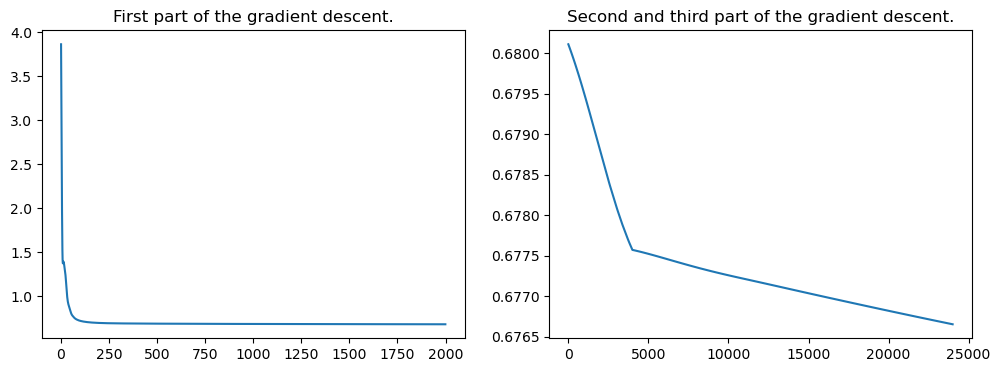

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"])
plt.title("First part of the gradient descent.")
plt.subplot(1, 2, 2)
plt.plot(history2["train_loss"] + history3["train_loss"])
plt.title("Second and third part of the gradient descent.")

In [ ]:
cmnl.trainable_weights

[<tf.Variable 'income_w_0:0' shape=(1, 3) dtype=float32, numpy=array([[-0.08402935, -0.02359889, -0.03233607]], dtype=float32)>,
 <tf.Variable 'cost_w_1:0' shape=(1, 1) dtype=float32, numpy=array([[-0.05140925]], dtype=float32)>,
 <tf.Variable 'freq_w_2:0' shape=(1, 1) dtype=float32, numpy=array([[0.09645309]], dtype=float32)>,
 <tf.Variable 'ovt_w_3:0' shape=(1, 1) dtype=float32, numpy=array([[-0.04099124]], dtype=float32)>,
 <tf.Variable 'ivt_w_4:0' shape=(1, 4) dtype=float32, numpy=
 array([[ 0.05871331, -0.00726127, -0.00368654, -0.00105641]],
       dtype=float32)>,
 <tf.Variable 'intercept_w_5:0' shape=(1, 3) dtype=float32, numpy=array([[-1.6874398 , -0.39639896,  1.1344571 ]], dtype=float32)>]

In [ ]:
cmnl.evaluate(canada_dataset)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6766487>

### References

[1] ModeCanada dataset in *Application and interpretation of nested logit models of intercity mode choice*, Christophier, V. F.; Koppelman, S. (1993)\
[2] Conditional MultinomialLogit, Train, K.; McFadden, D.; Ben-Akiva, M. (1987)\
[3] Siwssmetro dataset in *The acceptance of modal innovation: The case of Swissmetro*, Bierlaire, M.; Axhausen, K.; Abay, G (2001)\